<a href="https://colab.research.google.com/github/Turakulov/Python/blob/master/LentaRu_news_parsing%26clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install pymorphy2

import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re

from datetime import datetime
from datetime import timedelta

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

from sklearn import preprocessing

import numpy as np
import nltk
nltk.download(['averaged_perceptron_tagger_ru', 'stopwords'])
stopwords = nltk.corpus.stopwords.words('russian')

stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from tqdm import tqdm
import pymorphy2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 7.1MB 5.8MB/s 
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
datasetLength = 1400
itterLen = 0
pd.set_option('display.max_rows',datasetLength)
df = pd.DataFrame(columns=['news','rubric'], index = range(datasetLength))

In [0]:
# set start and stop date like this -> "2018/04/27"

def parsing(startDate, stopDate, itterLen, datasetLength):
    
  start = datetime.strptime(startDate, "%Y/%m/%d")
  stop = datetime.strptime(stopDate, "%Y/%m/%d")
  rubList = ['Россия','Дом','Спорт']
  while start < stop:
    start = start + timedelta(days=1)  # increase day one by one
    now = start.strftime("%Y/%m/%d")
    
    h3s=BeautifulSoup(requests.get(f"http://lenta.ru/{now}/").text, "html5lib").find_all("h3")

    links=["http://lenta.ru"+l.find_all("a")[0]["href"] for l in h3s]
    for i in range(len(links)):
      if itterLen == datasetLength-1:
        return
    
      txt = BeautifulSoup(requests.get(links[i]).text, "html.parser").find_all("div")
      rubric = re.findall('<a class="b-header__block" href="/rubrics/[a-zA-Z]+/">(.+?)</a>', str(txt))
    
      for x in rubList:
        if len(rubric) <= 1:
          if rubric != x:
            continue
          else:
            article = BeautifulSoup(" ".join([p.text for p in BeautifulSoup(requests.get(links[i]).text, "html.parser").find_all("p")]), "html5lib").get_text().replace("\xa0", " ")
            df.loc[itterLen].news = article
            df.loc[itterLen].rubric = rubric
            itterLen += 1
        else:
          if rubric[0] != x:
            continue
          else:
            article = BeautifulSoup(" ".join([p.text for p in BeautifulSoup(requests.get(links[i]).text, "html.parser").find_all("p")]), "html5lib").get_text().replace("\xa0", " ")
            df.loc[itterLen].news = article
            df.loc[itterLen].rubric = rubric[0]
            itterLen += 1

In [0]:
parsing("2018/04/01", "2018/06/01", itterLen, datasetLength)


In [0]:
df = df.drop(1189)
df = df.reset_index(drop=True)

In [0]:
df.to_csv("df.csv", index=False, encoding="utf-8")

In [66]:
# df = pd.read_csv('Nastya.csv', encoding='utf-8') 
df

,news,rubric
0,Столица притягивает молодых людей из провинции...,Дом
1,Правительство России распределило между 10 рег...,Спорт
2,Британский боксер-супертяж Дэвид Прайс поделил...,Спорт
3,Льготы для бывшего главы Кемеровской области А...,Россия
4,Арест владельцев Группы «Сумма» братьев Магоме...,Россия
...,...,...
1392,Чемпион Абсолютного бойцовского чемпионата (UF...,Спорт
1393,Британский боец смешанного стиля (MMA) Пол Дей...,Спорт
1394,Заместитель спортивного директора «Зенита» Вяч...,Спорт
1395,Израильский футбольный клуб «Бейтар» добавит к...,Спорт


In [0]:
morph = pymorphy2.MorphAnalyzer()

imp_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']

def getMostFrequentWordsFiltered(text):
    
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    text = ' '.join(words)
    
    counter=CountVectorizer(ngram_range=(1,2), stop_words=stopwords, token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
    res=counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:5]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

In [6]:
freqwords = []
vocabs = []
for i in tqdm(range(df.shape[0])):
    fw, v = getMostFrequentWordsFiltered(df.news.iloc[i])
    freqwords.append(fw)
    vocabs.append(v)
    
df['Vocabular'] = vocabs
df['Freq Words'] = freqwords
df.head(10)

100%|██████████| 1397/1397 [02:00<00:00, 11.64it/s]


,news,rubric,Vocabular,Freq Words
0,Столица притягивает молодых людей из провинции...,Дом,"{'столица': 3, 'притягивать': 1, 'молодая': 3,...","[маша, весь, квартира, людмила, москва]"
1,Правительство России распределило между 10 рег...,Спорт,"{'правительство': 2, 'россия': 1, 'распределит...","[год, миллион, мир, проведение, рубль]"
2,Британский боксер-супертяж Дэвид Прайс поделил...,Спорт,"{'британский': 1, 'боксёр-супертяж': 1, 'дэвид...","[прайс, весь, поветкин, бой, боксёр]"
3,Льготы для бывшего главы Кемеровской области А...,Россия,"{'льгота': 1, 'бывший': 3, 'глава': 3, 'кемеро...","[бывший, глава, тулеев, бывший глава, глава ке..."
4,Арест владельцев Группы «Сумма» братьев Магоме...,Россия,"{'арест': 1, 'владелец': 2, 'группа': 2, 'сумм...","[магомедов, песок, дело, сказать, средство]"
5,Глава Московской области Андрей Воробьев поруч...,Россия,"{'глава': 1, 'московский': 1, 'область': 1, 'а...","[участок, паводковый, подмосковье, автомобильн..."
6,"Полузащитник английского «Ливерпуля», лидер сб...",Спорт,"{'полузащитник': 1, 'английский': 2, 'ливерпул...","[реал, сборный, египет, клуб, ливерпуль]"
7,"В Ярославле был избит актер, игравший культово...",Россия,"{'ярославль': 10, 'избитый': 2, 'актёр': 2, 'и...","[ярославль, кафе, новость, аниматор, виллидж]"
8,Деятели культуры из глубинки нашли себе заступ...,Россия,"{'деятель': 1, 'культура': 8, 'глубинка': 1, '...","[музей, весь, приложение, возможность, информа..."
9,Госдума намерена до конца 2018 года обязать вл...,Дом,"{'госдума': 3, 'намерить': 1, 'конец': 2, 'год...","[комитет, торговый, торговый центр, центр, без..."


In [0]:
def normalizePymorphy2(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words

In [8]:
tfc = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)
tfr = tfc.fit_transform([' '.join(normalizePymorphy2(n)) for n in df.news])

freqwords = []
for i in tqdm(range(df.shape[0])):

    tfs = [(k,tfr[i][0, tfc.vocabulary_.get(k)]) for k in df.Vocabular.iloc[i] 
         if k in tfc.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:10]]
    txt = ' '.join(fw)
    freqwords.append(txt)
  
df['Tfidf'] = freqwords
df.head(10)

100%|██████████| 1397/1397 [00:41<00:00, 33.67it/s]


,news,rubric,Vocabular,Freq Words,Tfidf
0,Столица притягивает молодых людей из провинции...,Дом,"{'столица': 3, 'притягивать': 1, 'молодая': 3,...","[маша, весь, квартира, людмила, москва]",маша людмила лена дочка родитель квартира дочь...
1,Правительство России распределило между 10 рег...,Спорт,"{'правительство': 2, 'россия': 1, 'распределит...","[год, миллион, мир, проведение, рубль]",подготовка проведение проведение чемпионат мир...
2,Британский боксер-супертяж Дэвид Прайс поделил...,Спорт,"{'британский': 1, 'боксёр-супертяж': 1, 'дэвид...","[прайс, весь, поветкин, бой, боксёр]",прайс поветкин боксёр раунд летний британец по...
3,Льготы для бывшего главы Кемеровской области А...,Россия,"{'льгота': 1, 'бывший': 3, 'глава': 3, 'кемеро...","[бывший, глава, тулеев, бывший глава, глава ке...",тулеев народный губернатор глава кемеровский б...
4,Арест владельцев Группы «Сумма» братьев Магоме...,Россия,"{'арест': 1, 'владелец': 2, 'группа': 2, 'сумм...","[магомедов, песок, дело, сказать, средство]",магомедов песок владелец группа группа сумма б...
5,Глава Московской области Андрей Воробьев поруч...,Россия,"{'глава': 1, 'московский': 1, 'область': 1, 'а...","[участок, паводковый, подмосковье, автомобильн...",паводковый участок подтопление внимание участо...
6,"Полузащитник английского «Ливерпуля», лидер сб...",Спорт,"{'полузащитник': 1, 'английский': 2, 'ливерпул...","[реал, сборный, египет, клуб, ливерпуль]",сборный египет реал сало египет ливерпуль лиде...
7,"В Ярославле был избит актер, игравший культово...",Россия,"{'ярославль': 10, 'избитый': 2, 'актёр': 2, 'и...","[ярославль, кафе, новость, аниматор, виллидж]",ярославль кафе гамбино виллидж гамбино виллидж...
8,Деятели культуры из глубинки нашли себе заступ...,Россия,"{'деятель': 1, 'культура': 8, 'глубинка': 1, '...","[музей, весь, приложение, возможность, информа...",музей приложение возможность весь наш культурн...
9,Госдума намерена до конца 2018 года обязать вл...,Дом,"{'госдума': 3, 'намерить': 1, 'конец': 2, 'год...","[комитет, торговый, торговый центр, центр, без...",торговый центр торговый кинотеатр детский коми...


In [9]:
tfr

<1397x183441 sparse matrix of type '<class 'numpy.float64'>'
	with 377988 stored elements in Compressed Sparse Row format>

In [0]:
df = df.drop(['Vocabular'], axis=1)
df = df.drop(['Freq Words'], axis=1)

In [0]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

In [29]:
crit = []
sil = []
ari = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k,n_jobs= -1, random_state=1).fit(tfr)
    cluster_labels = kmeans.predict(tfr)
    crit.append(np.sqrt(kmeans.inertia_))
    sil.append(silhouette_score(tfr, cluster_labels))
    ari.append(adjusted_rand_score(df['rubric'], cluster_labels))


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


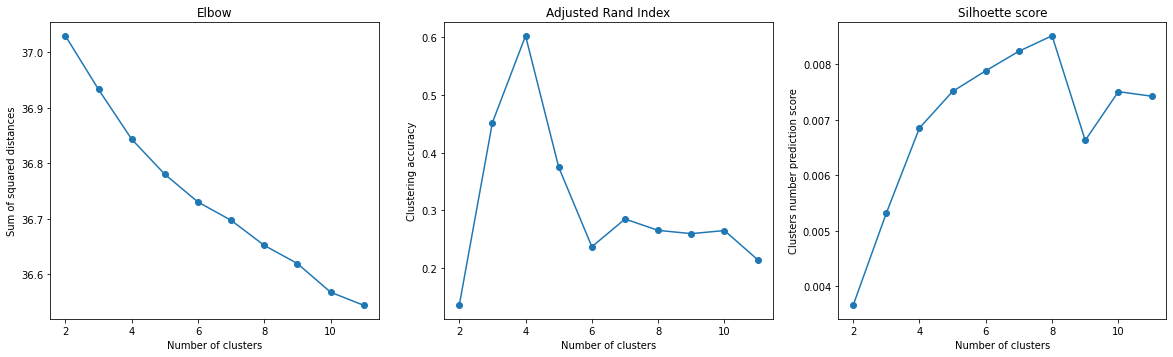

In [63]:
plt.rcParams['figure.figsize'] = (20, 12)

ax1 = plt.subplot(234)
ax1.plot(range(2,12), crit, marker='o')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Sum of squared distances')
ax1.set_title('Elbow')

ax2 = plt.subplot(235)
ax2.plot(range(2,12), ari, marker='o')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Clustering accuracy')
ax2.set_title('Adjusted Rand Index')

ax3 = plt.subplot(236)
ax3.plot(range(2,12), sil, marker='o')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Clusters number prediction score')
ax3.set_title('Silhoette score')

plt.show()

In [39]:
print(df.groupby('rubric')['news'].nunique())

rubric
Дом       261
Россия    594
Спорт     542
Name: news, dtype: int64


In [0]:
kmeans = KMeans(n_clusters=3, n_jobs=-1).fit(tfr)
cluster_labels = kmeans.predict(tfr)

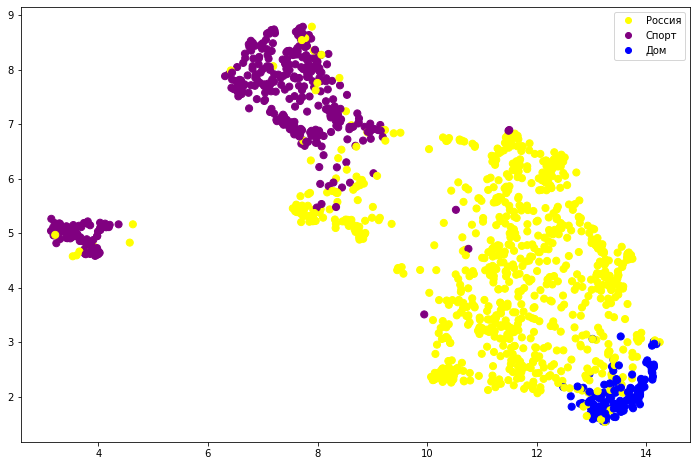

In [56]:
import umap
plt.rcParams['figure.figsize'] = (12, 8)
show_reduced = umap.UMAP(n_neighbors=50).fit_transform(tfr)

classes = ['Россия', 'Спорт', 'Дом']
colours = ListedColormap(['yellow','purple','blue'])
scatter = plt.scatter(show_reduced[:,0], show_reduced[:,1], c=cluster_labels, cmap=colours, s=50)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

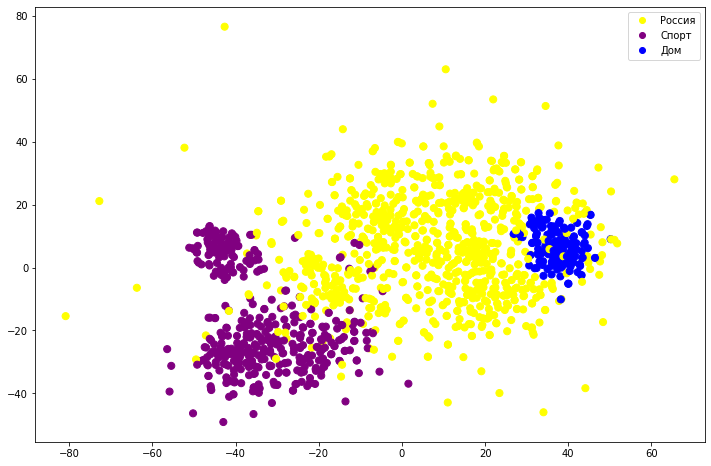

In [62]:
from sklearn.manifold import TSNE

show_reduced = TSNE(perplexity=60).fit_transform(tfr)

classes = ['Россия', 'Спорт', 'Дом']
colours = ListedColormap(['yellow','purple','blue'])
scatter = plt.scatter(show_reduced[:,0], show_reduced[:,1], c=cluster_labels, cmap=colours, s=50)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)